In [1]:
import torchvision
import numpy as np
from torch.utils.data import DataLoader
import torch as t

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def collate_fn(batch):

    # Puts each data field into a tensor with outer dimension batch size
    assert isinstance(batch[0], tuple)
    trans = torchvision.transforms.ToTensor()
    batch_size = len(batch)
    
    num_total_points = 784
    context_x, context_y, target_x, target_y = list(), list(), list(), list()
    conditional_y = list()
    for d, _ in batch:
        d = trans(d)
        total_idx = range(784)
        total_idx = list(map(lambda x: (x//28, x%28), total_idx))
        c_idx = None
        if get_top_half:
            c_idx = range(392)
            c_idx = list(map(lambda x: (x//28, x%28), c_idx))
        elif get_left_half:
            c_idx = range(392)
            c_idx = list(map(lambda x: (x%28, x//28), c_idx))
        else:
            c_idx = np.random.choice(range(784), num_total_points, replace=False)
            c_idx = list(map(lambda x: (x//28, x%28), c_idx))
            c_idx = c_idx[:num_context]
        c_x, c_y, total_x, total_y = list(), list(), list(), list()
        f_y = list()
        for idx in c_idx:
            c_y.append(d[:, idx[0], idx[1]])
            c_x.append((idx[0] / 27., idx[1] / 27.))
        for idx in total_idx:
            total_y.append(d[:, idx[0], idx[1]])
            total_x.append((idx[0] / 27., idx[1] / 27.))
            if idx in c_idx:
                f_y.append(d[:, idx[0], idx[1]])
            else:
                f_y.append(0)
        c_x, c_y, total_x, total_y, f_y = list(map(lambda x: t.FloatTensor(x), (c_x, c_y, total_x, total_y, f_y)))
        context_x.append(c_x)
        context_y.append(c_y)
        target_x.append(total_x)
        target_y.append(total_y)
        conditional_y.append(f_y) 
        
        
    context_x = t.stack(context_x, dim=0)
    context_y = t.stack(context_y, dim=0).unsqueeze(-1)
    target_x = t.stack(target_x, dim=0)
    target_y = t.stack(target_y, dim=0).unsqueeze(-1)
    conditional_y = t.stack(conditional_y, dim=0).unsqueeze(-1)
    
    return context_x, context_y, target_x, target_y, conditional_y

In [3]:
def plot_img(model, dloader):
    fig = plt.figure()
    model.eval()
    for i, d in enumerate(dloader):
        context_x, context_y, target_x, target_y, conditional_y = d
        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        pred_y, _, _ = model(context_x, context_y, target_x, None) # Test

        #fig.add_subplot(1,2,1)
        #fig.add_subplot(1,2,2)
        subplot = fig.add_subplot(1, 2, 1)
        subplot.axis('off')
        subplot.imshow(target_y.squeeze(0).view(-1,28).detach().numpy(), cmap='gray')
        subplot = fig.add_subplot(1, 2, 2)
        subplot.axis('off')
        subplot.imshow(pred_y.cpu().squeeze(0).view(-1,28).detach().numpy(), cmap='gray')

        if i == 1:
            break
    plt.show()

In [4]:
import import_ipynb
from ANP import get_model as ag
from NP import get_model as ng
from Gated_NP import get_model as gg
from Ladder_GNP import get_model as lg

model_name = 'LGNP'
model = None
if model_name == 'NP':
    model = ng().cuda()
elif model_name == 'ANP':
    model = ag().cuda()
elif model_name == 'GNP':
    model = gg().cuda()
elif model_name == 'LGNP':
    model = lg().cuda()
state_dict = t.load('./checkpoint/'+model_name+'_'+'100001.pth.tar')
model.load_state_dict(state_dict=state_dict[model_name])

importing Jupyter notebook from ANP.ipynb
importing Jupyter notebook from NP.ipynb
importing Jupyter notebook from Gated_NP.ipynb
importing Jupyter notebook from Ladder_GNP.ipynb


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

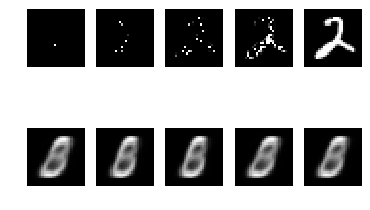

In [5]:
get_top_half=False
get_left_half=False
num_contexts = [10, 30, 100, 300, 784]

test_dataset = torchvision.datasets.MNIST('./mnist', train=False, download=False)
test_data_len = len(test_dataset)
np.random.seed(94) #80
tindices = np.random.choice(range(test_data_len), 1, replace=False)
tdataset = t.utils.data.Subset(test_dataset, tindices)
fig = plt.figure()
for j, n in enumerate(num_contexts):
    num_context = n # half of total points
    
    dloader = DataLoader(tdataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
    
    model.eval()
    for i, d in enumerate(dloader):
        context_x, context_y, target_x, target_y, conditional_y = d
        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        t.manual_seed(0)
        pred_y, _, _ = model(context_x, context_y, target_x, None) # Test
        #fig.add_subplot(1,2,1)
        #fig.add_subplot(1,2,2)
        subplot = fig.add_subplot(2, len(num_contexts), j+1)
        subplot.axis('off')
        subplot.imshow(conditional_y.squeeze(0).view(-1,28).detach().numpy(), cmap='gray')
        subplot = fig.add_subplot(2, len(num_contexts), len(num_contexts)+j+1)
        subplot.axis('off')
        subplot.imshow(pred_y.cpu().squeeze(0).view(-1,28).detach().numpy(), cmap='gray')

plt.show()

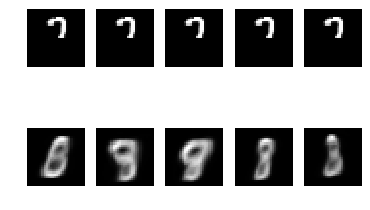

In [6]:
get_top_half=True
get_left_half=False

test_dataset = torchvision.datasets.MNIST('./mnist', train=False, download=False)
test_data_len = len(test_dataset)

num_context = 200
dloader = DataLoader(tdataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
fig = plt.figure()
for j, n in enumerate(num_contexts):
    num_context = n # half of total points
    
    model.eval()
    for i, d in enumerate(dloader):
        context_x, context_y, target_x, target_y, conditional_y = d
        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        t.manual_seed(j)
        pred_y, _, _ = model(context_x, context_y, target_x, None) # Test

        #fig.add_subplot(1,2,1)
        #fig.add_subplot(1,2,2)
        subplot = fig.add_subplot(2, len(num_contexts), j+1)
        subplot.axis('off')
        subplot.imshow(conditional_y.squeeze(0).view(-1,28).detach().numpy(), cmap='gray')
        subplot = fig.add_subplot(2, len(num_contexts), len(num_contexts)+j+1)
        subplot.axis('off')
        subplot.imshow(pred_y.cpu().squeeze(0).view(-1,28).detach().numpy(), cmap='gray')

plt.show()

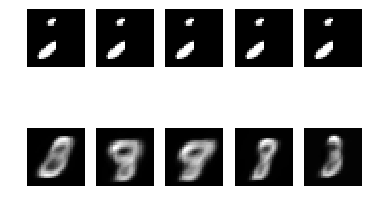

In [7]:
get_top_half=False
get_left_half=True

test_dataset = torchvision.datasets.MNIST('./mnist', train=False, download=False)
test_data_len = len(test_dataset)

num_context = 200
dloader = DataLoader(tdataset, batch_size=1, collate_fn=collate_fn, shuffle=False)
fig = plt.figure()
for j, n in enumerate(num_contexts):
    num_context = n # half of total points
    
    model.eval()
    for i, d in enumerate(dloader):
        context_x, context_y, target_x, target_y, conditional_y = d
        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        t.manual_seed(j)
        pred_y, _, _ = model(context_x, context_y, target_x, None) # Test

        #fig.add_subplot(1,2,1)
        #fig.add_subplot(1,2,2)
        subplot = fig.add_subplot(2, len(num_contexts), j+1)
        subplot.axis('off')
        subplot.imshow(conditional_y.squeeze(0).view(-1,28).detach().numpy(), cmap='gray')
        subplot = fig.add_subplot(2, len(num_contexts), len(num_contexts)+j+1)
        subplot.axis('off')
        subplot.imshow(pred_y.cpu().squeeze(0).view(-1,28).detach().numpy(), cmap='gray')

plt.show()